# GAN Tutorial 2

The aim of the previous notebook was to illustrate the structure and standard training method for Generative Adversarial Networks (GANs), highlighting key points in the theory of GANs and elucidating the topic with a working example, using Tensorflow and Keras to train a GAN on the MNIST dataset. In this notebook we are going to build on that work to train a GAN to generate convincing images from any given class. In order to do this we will take advantage of the class labels present in the MNIST dataset - this is crucial information and helps in the training immensely. We must restructure the GAN slightly to allow the generator and discriminator to take multiple inputs and outputs, which is remarkably simple with the Keras functional API. The structure of our GAN will be as follows:

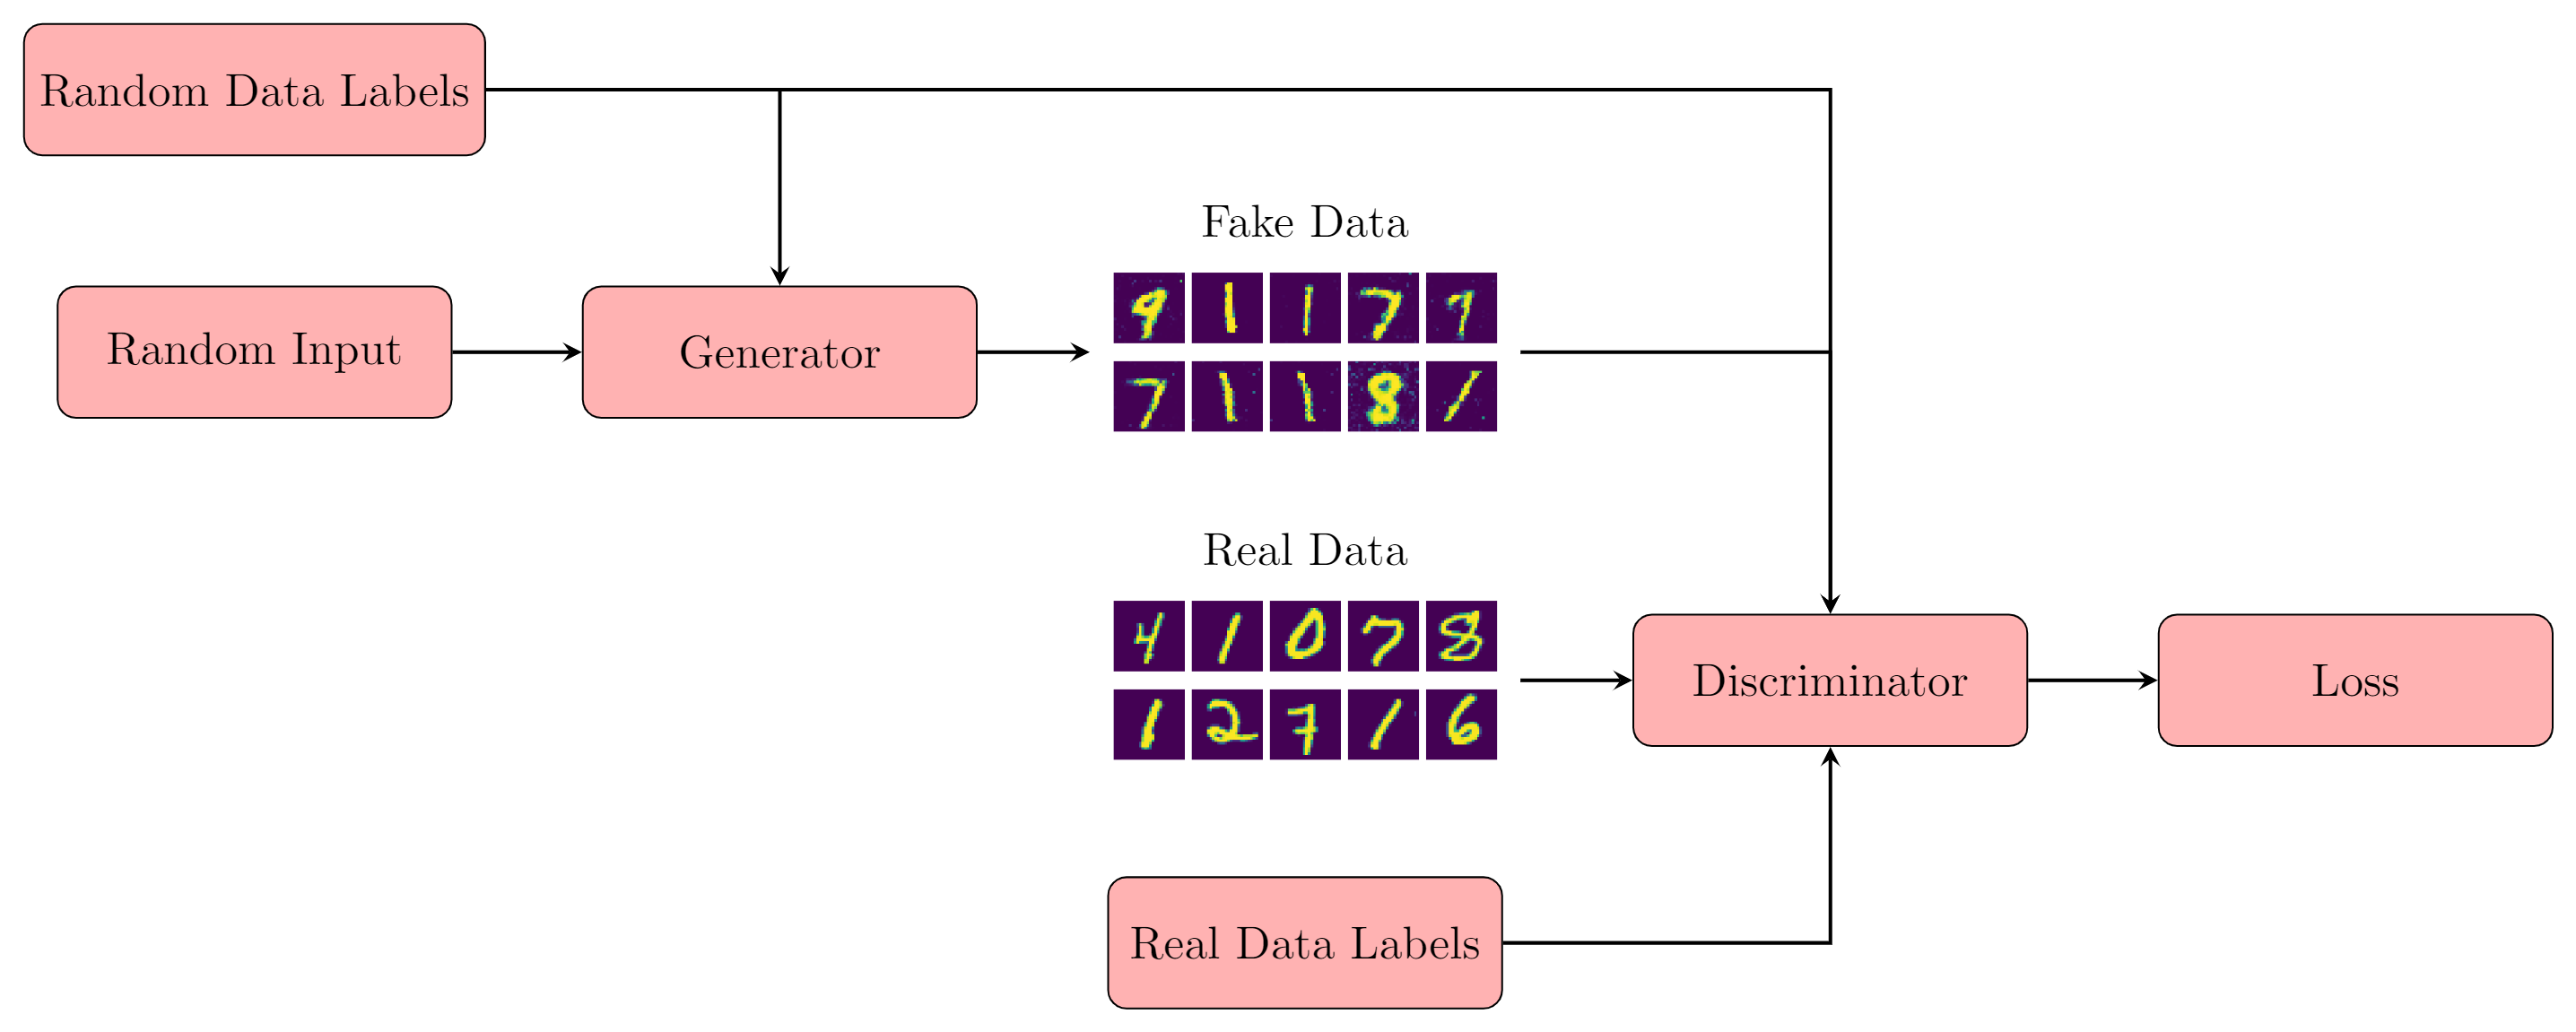

The generator must take random noise as input as before, but also a randomly selected class that it should generate. This means that, once trained, the generator should produce a digit from any class we choose. The discriminator will also take two inputs, the first being images, the second being corresponding class labels. This will allow the discriminator to make its decision of whether the image is real or fake not just based on how convincing the image is as a digit, but based on whether the digit belongs to the given class, which will force the generator to draw images from the correct class in order to perform well.

In [1]:
# Required modules and functions

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, Reshape, Flatten, Concatenate, BatchNormalization #Layers
from tensorflow.keras.layers import LeakyReLU #Activations
from tensorflow.keras.optimizers import Adam #Optimisers

import matplotlib.pyplot as plt
import time
import random
import tqdm

import numpy as np

In [2]:
# Setting global random seed for reproducibility
tf.random.set_seed(1234)

# Number of data features
N_FEATS = 10

# MNIST is black and white, so 1 channel
IMAGE_CHANNELS = 1

# Layout for displaying generated images 
PREVIEW_ROWS = 2
PREVIEW_COLS = 5

# Size vector to generate images from
SEED_SIZE = 100

# Configuration
EPOCHS = 100
BATCH_SIZE = 128
BUFFER_SIZE = 60000

We are using the MNIST dataset provided by the tensorflow_datasets module. The data is loaded, the pixel values scaled to range between -1 and 1, the range of the tanh activation function which will be used in the last layer of the generator. The data is then shuffled and batched according to the BATCH_SIZE and BUFFER_SIZE parameters. We use Buffer size of 60,000 (length of the dataset) so that the data is fully shuffled, and a Batch size of 128. Batch size can be tweaked, but be mindful of available RAM.

In [3]:
def scale_images(imgs):
    return 2.*tf.cast(imgs, tf.float32)/255. - 1

#Loading the data    
(mnist_train, label_train), (mnist_test, label_test) = tfds.load('mnist',
                                                                 split=['train', 'test'],
                                                                 batch_size=-1,
                                                                 as_supervised=True)
# Scale
mnist_train = scale_images(mnist_train)
label_train = tf.one_hot(label_train, depth=N_FEATS)

# Shuffle and batch
dataset = tf.data.Dataset.from_tensor_slices((mnist_train, label_train)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

The simplicity of MNIST allows us to get to grips with GANs with a simple dense structure. We will use a generator and discriminator with 3 dense hidden layers. Since we need to generate 28 x 28 images, the final layer will have 1024 units, which can then be reshaped into the desired format. The other parameters can be played with. We will also use the standard tanh activation in the last layer, with the other layers having Leaky ReLu.

In [4]:
def create_generator():
    inputs_rand = Input(shape=(SEED_SIZE,))
    inputs_feats = Input(shape=(N_FEATS,))
    inputs = Concatenate()([inputs_rand, inputs_feats])
    
    # add the hidden layers
    x = Dense(256, activation='relu')(inputs)
    x = Dense(units=512, activation='relu')(x)
    x = Dense(units=1024, activation='relu')(x)
    
    # add the output layer
    x = Dense(units=28*28, activation='tanh')(x)

    output = Reshape((28, 28, 1), input_shape=(28 * 28,))(x)
        
    generator = Model(inputs=[inputs_rand, inputs_feats], outputs=[output, inputs_feats], name='Generator')
    return generator
g=create_generator()
g.summary()

Model: "Generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 110)          0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          28416       concatenate[0][0]        

The discriminator is the mirror image of the generator. This makes sense intuitively as it is trying to undo what the generator has done. It will predict 1 for 'Real', and 0 for 'Fake', so the sigmoid activation is used in the final layer. We use Leaky ReLu in the other layers again. This helps reduce the vanishing gradients problem which affects larger GANs in particular.

In [5]:
def create_discriminator():
    inputs_img = Input(shape=(28,28,1))
    inputs_feats = Input(shape=(N_FEATS,))
    x = Flatten()(inputs_img)

    # add hidden layers
    x = Dense(units=1024, activation='relu')(x)
    x = Dense(units=512, activation='relu')(x)
    x = Dense(units=256, activation='relu')(x)
    
    x = Concatenate()([x, inputs_feats])
    
    x = Dense(units=128, activation='relu')(x)
    
    # add output layer
    output = Dense(units=1, activation='sigmoid')(x)
    
    discriminator = Model(inputs=[inputs_img, inputs_feats], outputs=[output], name='Discriminator')
    return discriminator
d =create_discriminator()
d.summary()

Model: "Discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 784)          0           input_3[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 1024)         803840      flatten[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 512)          524800      dense_4[0][0]                    
______________________________________________________________________________________

In [6]:
def create_gan(discriminator, generator):
    #discriminator.trainable=False
    gan_input_rand = Input(shape=(100,), name='Random_Input')
    gan_input_feats = Input(shape=(N_FEATS,), name='Features_Input')
    x = generator([gan_input_rand, gan_input_feats])
    gan_output= discriminator(x)
    gan= Model(inputs=[gan_input_rand, gan_input_feats], outputs=gan_output)
    return gan
gan = create_gan(d,g)
gan.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Random_Input (InputLayer)       [(None, 100)]        0                                            
__________________________________________________________________________________________________
Features_Input (InputLayer)     [(None, 10)]         0                                            
__________________________________________________________________________________________________
Generator (Model)               [(None, 28, 28, 1),  1488912     Random_Input[0][0]               
                                                                 Features_Input[0][0]             
__________________________________________________________________________________________________
Discriminator (Model)           (None, 1)            1494273     Generator[1][0]              

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4,0.5)

In [ ]:
def plot_generated_images(epoch, generator, noise, feats, 
                          examples=PREVIEW_ROWS*PREVIEW_COLS, 
                          dim=(PREVIEW_ROWS, PREVIEW_COLS), 
                          figsize=(8,4)):
    
    generated_images = generator.predict([noise, feats])[0]
    generated_images = generated_images.reshape(examples,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')#, cmap='Greys')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'C://Users/ewand/Jupyter Projects/GAN/Output/Images/Dense_MNIST 4/dense_gan_generated_image {epoch}.png')
    plt.show()

In [ ]:
def training(epochs=1):
    
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    # Compiling models, 'trainable' only used when compiling, so doing it in this order means discriminator will train
    # when discriminator.train_on_batch() is called, but not when gan.train_on_batch() is called.
    discriminator.compile(loss='binary_crossentropy', optimizer=discriminator_optimizer)
    discriminator.trainable = False
    gan.compile(loss='binary_crossentropy', optimizer=generator_optimizer, metrics=['accuracy'])
    
    # Use fixed noise to generate example images
    example_noise = tf.random.normal(shape=(PREVIEW_ROWS*PREVIEW_COLS, 100), mean=0, stddev=1)
    example_feats = tf.one_hot(range(10), depth=N_FEATS)
    
    plot_generated_images(0, generator, example_noise, example_feats)
    
    for e in range(1,epochs+1):
        print(f'Epoch {e}')
        for batch in tqdm.notebook.tqdm(dataset):
            
            # Generate random noise as an input for the generator.
            noise = tf.random.normal(shape=(BATCH_SIZE, 100), mean=0, stddev=1)
            feats = tf.one_hot(tf.random.uniform(shape=(BATCH_SIZE,), minval=0, maxval=9, dtype=tf.int32), depth=N_FEATS)
            
            # Generate fake images from noise.
            generated_images = generator.predict([noise, feats])
            
            # Construct different batches of  real and fake data.
            X_imgs = tf.concat([batch[0], generated_images[0]], axis=0)
            X_feats = tf.concat([batch[1], generated_images[1]], axis=0)
            #X = tf.data.Dataset.from_tensor_slices((X_imgs, X_feats))
            
            # Labels for generated and real data, discriminator should map real images to 1, fakes to 0.
            # Soft labels are supposed to improve training.
            y_dis_real = tf.random.uniform(shape = (BATCH_SIZE,), minval=0.9, maxval=1)
            y_dis_fake = tf.random.uniform(shape = (BATCH_SIZE,), minval=0, maxval=0.1)
            y_dis = tf.concat([y_dis_real, y_dis_fake], axis=0)
            
            # Train discriminator on batch first. 
            discriminator.train_on_batch([X_imgs, X_feats], y_dis)
            
            # Now we are going to train the generator to make the discriminator predict incorrectly, that is map the fakes to 1.
            #noise = tf.random.normal(shape = (BATCH_SIZE, 100), mean=0, stddev=1)
            y_gen = tf.random.uniform(shape = (BATCH_SIZE,), minval=0.9, maxval=1)
                        
            # Then training the GAN with noise as input and targets as real makes the generator try to trick the discriminator.
            # This process of adversarial training will continue until the generator produces good results.
            gan.train_on_batch([noise, feats], y_gen)
            
        plot_generated_images(e, generator, example_noise, example_feats)
    return generator, discriminator
g, d = training(EPOCHS)

In [ ]:
fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(10,10))

for col in range(10):
    noise = tf.random.normal(shape=(1, 100), mean=0, stddev=1)
    for row in range(10):
        feat = np.reshape(tf.one_hot(row, depth=10), (1,10))
        generated_image = g.predict([noise, feat])[0]
        ax[row, col].imshow(np.squeeze(generated_image))
        ax[row, col].axis('off')
        
fig.savefig('C://Users/ewand/Jupyter Projects/GAN/Output/Images/100x100.png')
        

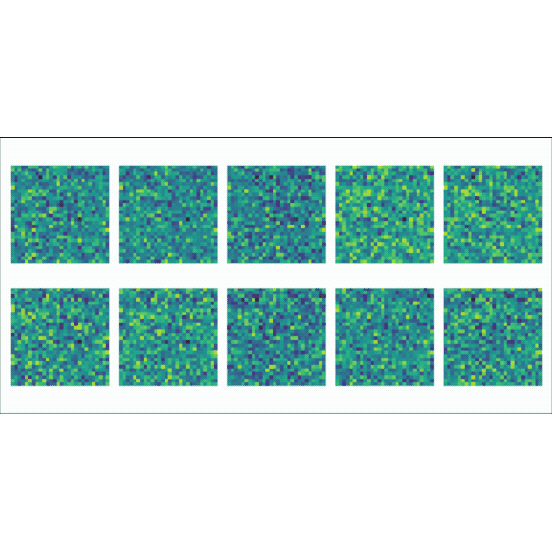

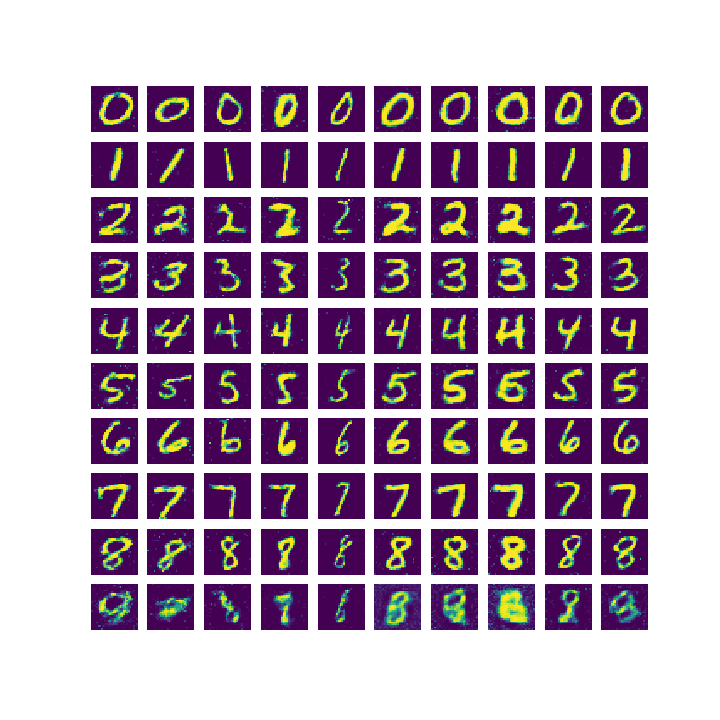